In [1]:
import theano
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
filename = '../../Dataset/heartbeatFeaturesB4.csv'
df = pd.read_csv(filename)

# Remove the extra column read

toremove = df.shape[1] -1 
df = df.iloc[:, 0:toremove]
df.head()

,stdPCA1,stdPCA2,stdPCA3,meanPCA1,meanPCA2,meanPCA3,meanS1,meanS2,stdS1,stdS2,...,minstdS1,maxstdS1,mmstdS1,minstdS2,maxstdS2,mmstdS2,posRatio,stdWavelet,meanWavelet,class
0,2.925073,1.603105,1.107265,-1.327246e-16,-2.224033e-17,2.511005e-18,472.0000,519.0000,26.57066,28.81666,...,24.65675,22.15827,20.00486,23.79636,25.31929,19.62142,0.086957,0.143258,-0.016102,Normal
1,3.003149,1.398531,1.245671,3.994780e-17,-5.461219e-17,-3.146381e-17,476.2105,480.1579,79.44780,79.73795,...,58.73258,79.29658,58.02636,60.56134,80.77381,61.31806,0.000000,0.164868,0.020342,Normal
2,2.906362,1.612006,1.189551,-2.873518e-17,4.745659e-17,1.567374e-17,489.6667,509.6250,21.94311,27.64023,...,16.47021,20.52481,14.64988,24.01983,24.41311,20.72116,0.000000,0.291671,-0.025297,Normal
3,2.915212,1.579173,1.217206,-1.107815e-17,-1.628307e-16,9.801752e-17,477.5000,491.7647,30.51374,17.26097,...,27.18428,28.52656,25.01699,14.72356,15.16122,12.24434,0.000000,0.077379,-0.000735,Normal
4,3.027328,1.368556,1.143924,-1.072735e-16,1.499522e-17,2.854859e-17,1364.5000,2427.0000,20.50610,0.00000,...,20.50610,20.50610,20.50610,0.00000,0.00000,0.00000,0.750000,0.064384,0.002975,Normal


# Some nice stats

In [3]:
# Check the Dimensions of the data

df.shape

(312, 27)

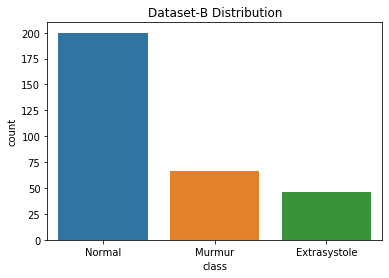

In [4]:
# Check the sitribution of the dataset

plot = sns.countplot(x='class', data=df).set_title('Dataset-B Distribution')

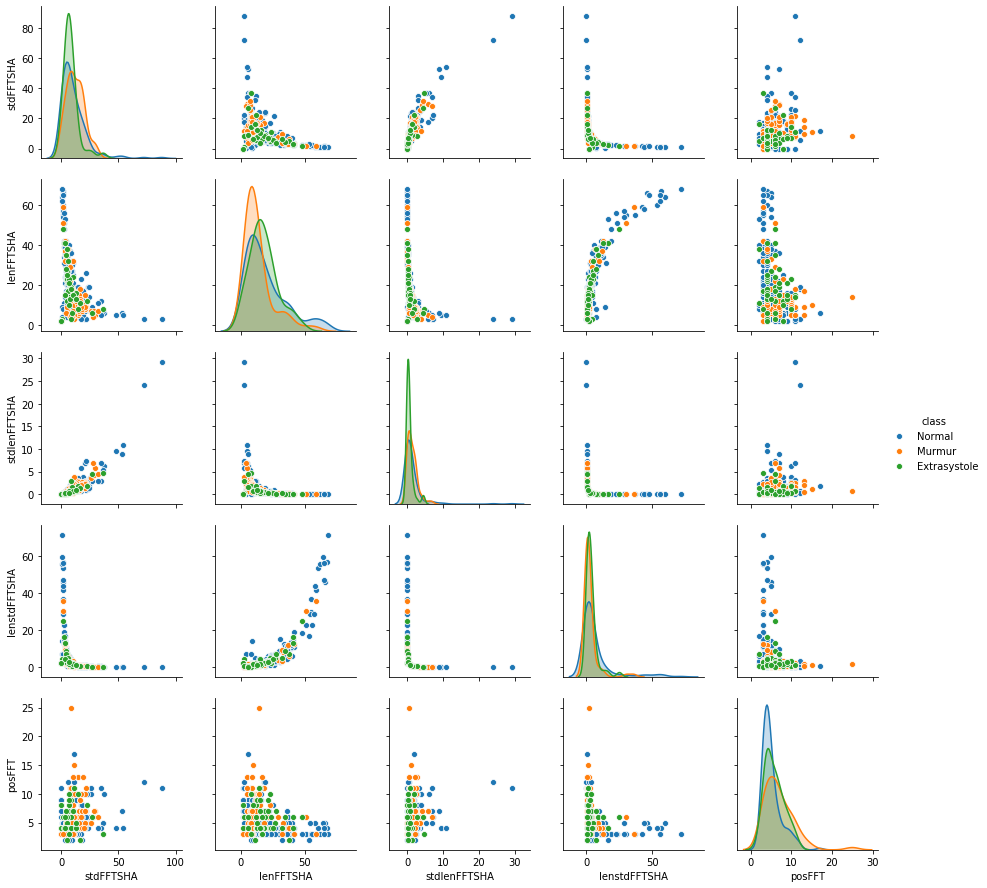

In [5]:
# Check some relationships of the different features

sns.pairplot(df, vars=df.columns[12:17], hue='class')

## Back to the real stuff - Conditioning the Data

In [6]:
# Only take this select set of features from the Dataset A

X = df.iloc[:,0:17]
X[['maxstdS1', 'maxstdS2', 'mmstdS1', 'mmstdS2']] = df[['maxstdS1', 'maxstdS2','mmstdS1', 'mmstdS2']]
X[['posRatio','stdWavelet','meanWavelet']] = df[['posRatio','stdWavelet','meanWavelet']]

# Normalise the features

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(x_scaled)

# Rename the columns

X.columns = [ 'stdPCA1', 'stdPCA2', 'stdPCA3', 'meanPCA1', 
               'meanPCA2', 'meanPCA3', 'meanS1', 'meanS2', 
          'stdS1', 'stdS2','rebuilError', 'ratios','stdFFTSHA' ,
          'lenFFTSHA', 'stdlenFFTSHA' ,'lenstdFFTSHA' ,'posFFT',
         'maxstdS1', 'maxstdS2', 'mmstdS1', 'mmstdS2',
         'posRatio','stdWavelet','meanWavelet']

X.head()

,stdPCA1,stdPCA2,stdPCA3,meanPCA1,meanPCA2,meanPCA3,meanS1,meanS2,stdS1,stdS2,...,stdlenFFTSHA,lenstdFFTSHA,posFFT,maxstdS1,maxstdS2,mmstdS1,mmstdS2,posRatio,stdWavelet,meanWavelet
0,0.638786,0.409461,0.503370,0.263359,0.366913,0.404606,0.063191,0.047157,0.039061,0.026406,...,0.016750,0.028118,0.173913,0.032574,0.029471,0.029409,0.017980,0.096618,0.223323,0.222477
1,0.727809,0.236116,0.786586,0.446894,0.282429,0.320283,0.064612,0.039029,0.116794,0.073067,...,0.064188,0.006984,0.304348,0.116572,0.094018,0.085303,0.056188,0.000000,0.264409,0.318822
2,0.617452,0.417003,0.671749,0.373890,0.548808,0.437275,0.069153,0.045195,0.032258,0.025328,...,0.233871,0.001569,0.130435,0.030173,0.028416,0.021536,0.018988,0.000000,0.505492,0.198169
3,0.627543,0.389182,0.728339,0.392658,0.000000,0.641646,0.065047,0.041458,0.044858,0.015817,...,0.211261,0.001788,0.347826,0.041936,0.017647,0.036777,0.011220,0.000000,0.098073,0.263103
4,0.755378,0.210717,0.578384,0.290411,0.464090,0.469229,0.364380,0.446460,0.030146,0.000000,...,0.004540,0.105028,0.130435,0.030146,0.000000,0.030146,0.000000,0.833333,0.073366,0.272911


In [7]:
# For testing later on ....
P = X.values[15:22,:]

In [8]:
# Get the classes

y = df.iloc[:,toremove-1:toremove]
y.head()

Y = pd.get_dummies(y['class'])
print(Y)

     Extrasystole  Murmur  Normal
0               0       0       1
1               0       0       1
2               0       0       1
3               0       0       1
4               0       0       1
..            ...     ...     ...
307             1       0       0
308             1       0       0
309             1       0       0
310             1       0       0
311             1       0       0

[312 rows x 3 columns]


In [9]:
# Randomise the dataset

X,Y = shuffle(X,Y,random_state=100)

In [10]:
X.head()

,stdPCA1,stdPCA2,stdPCA3,meanPCA1,meanPCA2,meanPCA3,meanS1,meanS2,stdS1,stdS2,...,stdlenFFTSHA,lenstdFFTSHA,posFFT,maxstdS1,maxstdS2,mmstdS1,mmstdS2,posRatio,stdWavelet,meanWavelet
309,0.042249,0.849297,0.890956,0.380867,0.410274,0.787674,0.059557,0.040332,0.097761,0.066757,...,0.154809,0.002615,0.173913,0.095597,0.082999,0.045744,0.017026,0.000000,0.055824,0.279593
169,0.575219,0.468849,0.569741,0.303563,0.750561,0.353813,0.145870,0.236345,0.000000,0.003888,...,0.000610,0.784777,0.043478,0.000000,0.004938,0.000000,0.003888,0.000000,0.076175,0.273732
1,0.727809,0.236116,0.786586,0.446894,0.282429,0.320283,0.064612,0.039029,0.116794,0.073067,...,0.064188,0.006984,0.304348,0.116572,0.094018,0.085303,0.056188,0.000000,0.264409,0.318822
27,0.807858,0.188924,0.432289,0.364804,0.355762,0.538205,0.046992,0.029630,0.237846,0.255484,...,0.002436,0.196133,0.086957,0.073036,0.043072,0.045319,0.024622,0.111111,0.265878,0.299967
126,0.602086,0.376342,0.604083,0.277930,0.364109,0.539179,0.158863,0.152968,0.491549,0.216067,...,0.005486,0.086843,0.130435,0.039015,0.162157,0.030146,0.131037,0.333333,0.159111,0.244806


In [11]:
# Split into training & Testing

from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state = 100)


In [12]:
# Check the proportions of classes for training

classes, count = np.unique(Y_train,axis=0,return_counts=True)

print(classes,'\n')
print("Training numbers : ",count, '\n')

[[0 0 1]
 [0 1 0]
 [1 0 0]] 

Training numbers :  [160  51  38] 



In [13]:
# Check the proportions of classes for testing

classes, count = np.unique(Y_test,axis=0,return_counts=True)

print(classes,'\n')
print("Training numbers : ",count, '\n')

[[0 0 1]
 [0 1 0]
 [1 0 0]] 

Training numbers :  [40 15  8] 



# Training

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [15]:
# Use sequential model
clf = Sequential()

W0915 20:19:01.931990 140617488103232 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [16]:
# Get dimension of the model from the dataset

x_dim = X.shape[1]
y_dim = Y.shape[1]

n_unit = int(np.floor((x_dim + y_dim)/2))

print(x_dim, y_dim,n_unit)

24 3 13


In [17]:
# Build the model

clf.add(Dense(activation = 'relu', input_dim = x_dim, units=n_unit, kernel_initializer= 'uniform'))


W0915 20:19:02.102375 140617488103232 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 20:19:02.104893 140617488103232 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [18]:
# Only use one hidden layer

layers = 1

clf.add(Dense(activation= 'relu', units = n_unit, kernel_initializer='uniform'))

In [19]:
# Adding the output layer

clf.add(Dense(activation = 'softmax', units=y_dim, kernel_initializer='uniform'))

In [20]:
# Finalise the model

clf.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

W0915 20:19:02.368025 140617488103232 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0915 20:19:02.403153 140617488103232 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0915 20:19:02.408963 140617488103232 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
# Start training

history = clf.fit(X_train, Y_train, batch_size=10, epochs=100, 
 validation_split=0.2  ,shuffle=True)

#validation_data=(X_test, Y_test) validation_split=0.2 

W0915 20:19:02.622949 140617488103232 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 199 samples, validate on 50 samples
Epoch 1/100
199/199 [==============================] - 0s 1ms/step - loss: 0.6338 - acc: 0.6667 - val_loss: 0.6312 - val_acc: 0.6667
Epoch 2/100
199/199 [==============================] - 0s 108us/step - loss: 0.6249 - acc: 0.6667 - val_loss: 0.6197 - val_acc: 0.6667
Epoch 3/100
199/199 [==============================] - 0s 116us/step - loss: 0.6061 - acc: 0.6667 - val_loss: 0.5959 - val_acc: 0.6667
Epoch 4/100
199/199 [==============================] - 0s 120us/step - loss: 0.5720 - acc: 0.6683 - val_loss: 0.5685 - val_acc: 0.6533
Epoch 5/100
199/199 [==============================] - 0s 114us/step - loss: 0.5455 - acc: 0.7571 - val_loss: 0.5558 - val_acc: 0.7467
Epoch 6/100
199/199 [==============================] - 0s 127us/step - loss: 0.5358 - acc: 0.7655 - val_loss: 0.5560 - val_acc: 0.7467
Epoch 7/100
199/199 [==============================] - 0s 112us/step - loss: 0.5287 - acc: 0.7655 - val_loss: 0.5543 - val_acc: 0.7467
Epoch 8/100


199/199 [==============================] - 0s 144us/step - loss: 0.4481 - acc: 0.7873 - val_loss: 0.5219 - val_acc: 0.7600
Epoch 62/100
199/199 [==============================] - 0s 142us/step - loss: 0.4463 - acc: 0.7923 - val_loss: 0.5213 - val_acc: 0.7467
Epoch 63/100
199/199 [==============================] - 0s 144us/step - loss: 0.4456 - acc: 0.7940 - val_loss: 0.5204 - val_acc: 0.7467
Epoch 64/100
199/199 [==============================] - 0s 121us/step - loss: 0.4462 - acc: 0.7889 - val_loss: 0.5210 - val_acc: 0.7533
Epoch 65/100
199/199 [==============================] - 0s 108us/step - loss: 0.4443 - acc: 0.7923 - val_loss: 0.5206 - val_acc: 0.7533
Epoch 66/100
199/199 [==============================] - 0s 106us/step - loss: 0.4439 - acc: 0.7940 - val_loss: 0.5209 - val_acc: 0.7600
Epoch 67/100
199/199 [==============================] - 0s 103us/step - loss: 0.4437 - acc: 0.7956 - val_loss: 0.5190 - val_acc: 0.7667
Epoch 68/100
199/199 [==============================] - 0s 10

### Plots

Text(0.5, 1.0, 'Training and Validation Loss for Dataset B')

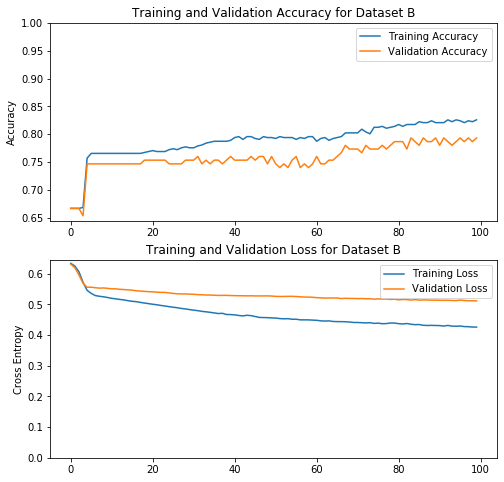

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy for Dataset B')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss for Dataset B')
#plt.savefig('./Models/A_80_81_No_Dropout_Validation_split.png')

In [23]:
print('Final Accuracy: ' ,val_acc[99]*100, '\tMean Accuracy :', np.mean(val_acc)*100, '\n\nTraining Accuracy: ', acc[99]*100 ,'\tMean Training Accuracy :', np.mean(acc)*100, )

Final Accuracy:  79.333336353302 	Mean Accuracy : 75.7800024867058 

Training Accuracy:  82.579566575774 	Mean Training Accuracy : 78.82412231747229


# Testing 123 Testing

In [24]:
Y_pred = clf.predict(X_test)

In [25]:
Y_pred = (Y_pred > 0.5)

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.values.argmax(axis=1),Y_pred.argmax(axis=1))
print(cm)

[[ 3  0  5]
 [ 4  9  2]
 [ 5  2 33]]


In [27]:
score = accuracy_score(Y_test.values.argmax(axis=1),Y_pred.argmax(axis=1))
print(score)

0.7142857142857143


In [28]:
print(classification_report(Y_test.values.argmax(axis=1),Y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.25      0.38      0.30         8
           1       0.82      0.60      0.69        15
           2       0.82      0.82      0.82        40

    accuracy                           0.71        63
   macro avg       0.63      0.60      0.61        63
weighted avg       0.75      0.71      0.73        63



In [29]:
# Logs..

#with open('./Logs/B_ANN_stats.log', 'a+') as f:
 #           f.write('\n==============================================================\n' + '\n '+ filename  +'\n\n' + str(cm) +'\n\n' + 'Dimensions: ' + str(x_dim) +' Layers: ' + str(layers) + '\n'+ 'Testing Accuracy: ' + str(val_acc[99]*100) + ' Training Acc: ' + str(acc[99]*100) + '\nTesting Score: '+ str(score) + '\n\n' + classification_report(Y_test.values.argmax(axis=1),Y_pred.argmax(axis=1)))

# Saving The Model


In [30]:
# import pickle

In [31]:
# model_name_ = '../../Models/ANN_Dataset_B_80_81_No_Dropout_Validation_split_v6.pkl'
# model = open(model_name_, "wb")
# pickle.dump(clf,model)
# model_pkl = open(model_name_, "rb")
# model_test = pickle.load(model_pkl)
# model_test.summary()

In [32]:
# model_test.predict_proba(P)

# Another way of Saving

In [33]:
# model_name = '../../Models/ANN_Dataset_B_80_81_No_Dropout_Validation_split_v6.h5'
# clf.save(model_name)
# new_model = keras.models.load_model(model_name)
# new_model.summary()

In [34]:
# new_predictions = new_model.predict(P)
# print(new_predictions )